<a href="https://colab.research.google.com/github/Norod/my-colab-experiments/blob/master/fun_with_stylegan2_furries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

%cd /content/
!pip install typeguard
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!git clone https://github.com/kylemcdonald/python-utils.git utils

TensorFlow 1.x selected.
/content
Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.
/content/stylegan2
Cloning into 'utils'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 242 (delta 86), reused 94 (delta 42), pack-reused 94
Receiving objects: 100% (242/242), 53.64 KiB | 8.94 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [0]:
%cd /content/stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

/content/stylegan2
CPU says hello.
GPU says hello.


In [0]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
from dnnlib.tflib.autosummary import autosummary

from utils.imutil import imshow, imresize
from utils.mosaic import make_mosaic

tflib.init_tf()

# Load pre-trained network from https://thisfursonadoesnotexist.com/
url = 'https://thisfursonadoesnotexist.com/model/network-e621-r-512-3194880.pkl'

with dnnlib.util.open_url(url, cache_dir='/tmp/') as f:
    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [0]:
import os

out_path = './out'

if os.path.isdir(out_path) == False:
    os.mkdir(out_path)


In [0]:
from PIL import Image

#Actual number of video clip frames is (number_of_images * 2)
number_of_images = 60 

# *********************************************
# If you wish to run again, change the number 
# below and start again from this cell
# following runs will be much quicker
# *********************************************
# Pick a seed for generating the random vectors
# *********************************************
random_seed = 402
# *********************************************

# Size of image grid
batch_size = 4

rnd = np.random.RandomState(random_seed)
latents = rnd.randn(batch_size, Gs.input_shape[1])
print('latents.shape = ' + str(latents.shape))

truncation_psi_vector_tmp = np.logspace(-1.2,1.2,num = number_of_images, base=2.0)
truncation_psi_offset = truncation_psi_vector_tmp[number_of_images - 1] + 0.01
truncation_psi_vector_1 = truncation_psi_vector_tmp - truncation_psi_offset
truncation_psi_vector_2 = np.absolute(np.flip(truncation_psi_vector_1))
truncation_psi_vector = np.concatenate((truncation_psi_vector_1, truncation_psi_vector_2), axis=None)
print("truncation_psi_vector " + str(truncation_psi_vector.shape) + " = " + str(truncation_psi_vector))

seed_path = out_path + '/' + str(random_seed)
if os.path.isdir(seed_path) == False:
    os.mkdir(seed_path)


latents.shape = (4, 512)
truncation_psi_vector (120,) = [-1.87212143 -1.85967383 -1.84687026 -1.83370054 -1.82015422 -1.8062205
 -1.79188833 -1.77714629 -1.76198268 -1.74638543 -1.73034214 -1.71384006
 -1.69686607 -1.67940668 -1.661448   -1.64297575 -1.62397525 -1.60443139
 -1.58432863 -1.563651   -1.54238204 -1.52050485 -1.49800204 -1.47485571
 -1.45104747 -1.42655838 -1.40136898 -1.37545923 -1.34880853 -1.32139571
 -1.29319896 -1.26419586 -1.23436336 -1.20367774 -1.1721146  -1.13964884
 -1.10625466 -1.0719055  -1.03657406 -1.00023224 -0.96285115 -0.92440107
 -0.88485143 -0.84417078 -0.80232679 -0.75928618 -0.71501474 -0.66947726
 -0.62263755 -0.57445835 -0.52490137 -0.4739272  -0.42149533 -0.36756405
 -0.3120905  -0.25503056 -0.19633888 -0.13596878 -0.07387228 -0.01
  0.01        0.07387228  0.13596878  0.19633888  0.25503056  0.3120905
  0.36756405  0.42149533  0.4739272   0.52490137  0.57445835  0.62263755
  0.66947726  0.71501474  0.75928618  0.80232679  0.84417078  0.88485143
  0

In [0]:
# Generate images

counter = 0
thumbnails = []
for i in truncation_psi_vector:
  print(i)
  fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  images = Gs.run(latents, None, minibatch = batch_size, truncation_psi=i, randomize_noise=True, output_transform=fmt)
  mosaic = make_mosaic(images)
  im = Image.fromarray(mosaic)
  im.save(seed_path + '/StyleGanImg_' + str(counter) + '.jpg')
  if counter % (number_of_images / 6) == 0:
    thumbnails.append(imresize(mosaic, max_side=256))
  
  counter = counter + 1

  

-1.8721214283460075
-1.8596738254128216
-1.846870257357528
-1.8337005446163317
-1.8201542165196163
-1.8062205029671679
-1.791888325865333
-1.7771462903193056
-1.7619826755735382
-1.746385425693075
-1.7303421399784003
-1.713840063106176
-1.696866074988037
-1.6794066803393752
-1.6614479979498211
-1.6429757496468937
-1.6239752489440427
-1.604431389364057
-1.5843286324285573
-1.563650995304024
-1.5423820380945366
-1.5205048507711216
-1.4980020397273206
-1.4748557139502838
-1.4510474707964003
-1.4265583813601501
-1.4013689754245489
-1.3754592259812206
-1.3488085333077886
-1.321395708589924
-1.2931989570750375
-1.2641958607442132
-1.2343633604886077
-1.2036777377761516
-1.172114595793968
-1.1396488400515212
-1.1062546584290711
-1.0719055006555727
-1.0365740571997004
-1.0002322375572235
-0.9628511479174557
-0.924401068191038
-0.8848514283807769
-0.8441707842767625
-0.8023267924564348
-0.7592861845697252
-0.7150147408888299
-0.6694772631015817
-0.6226375463267939
-0.5744583503293224
-0.5249013

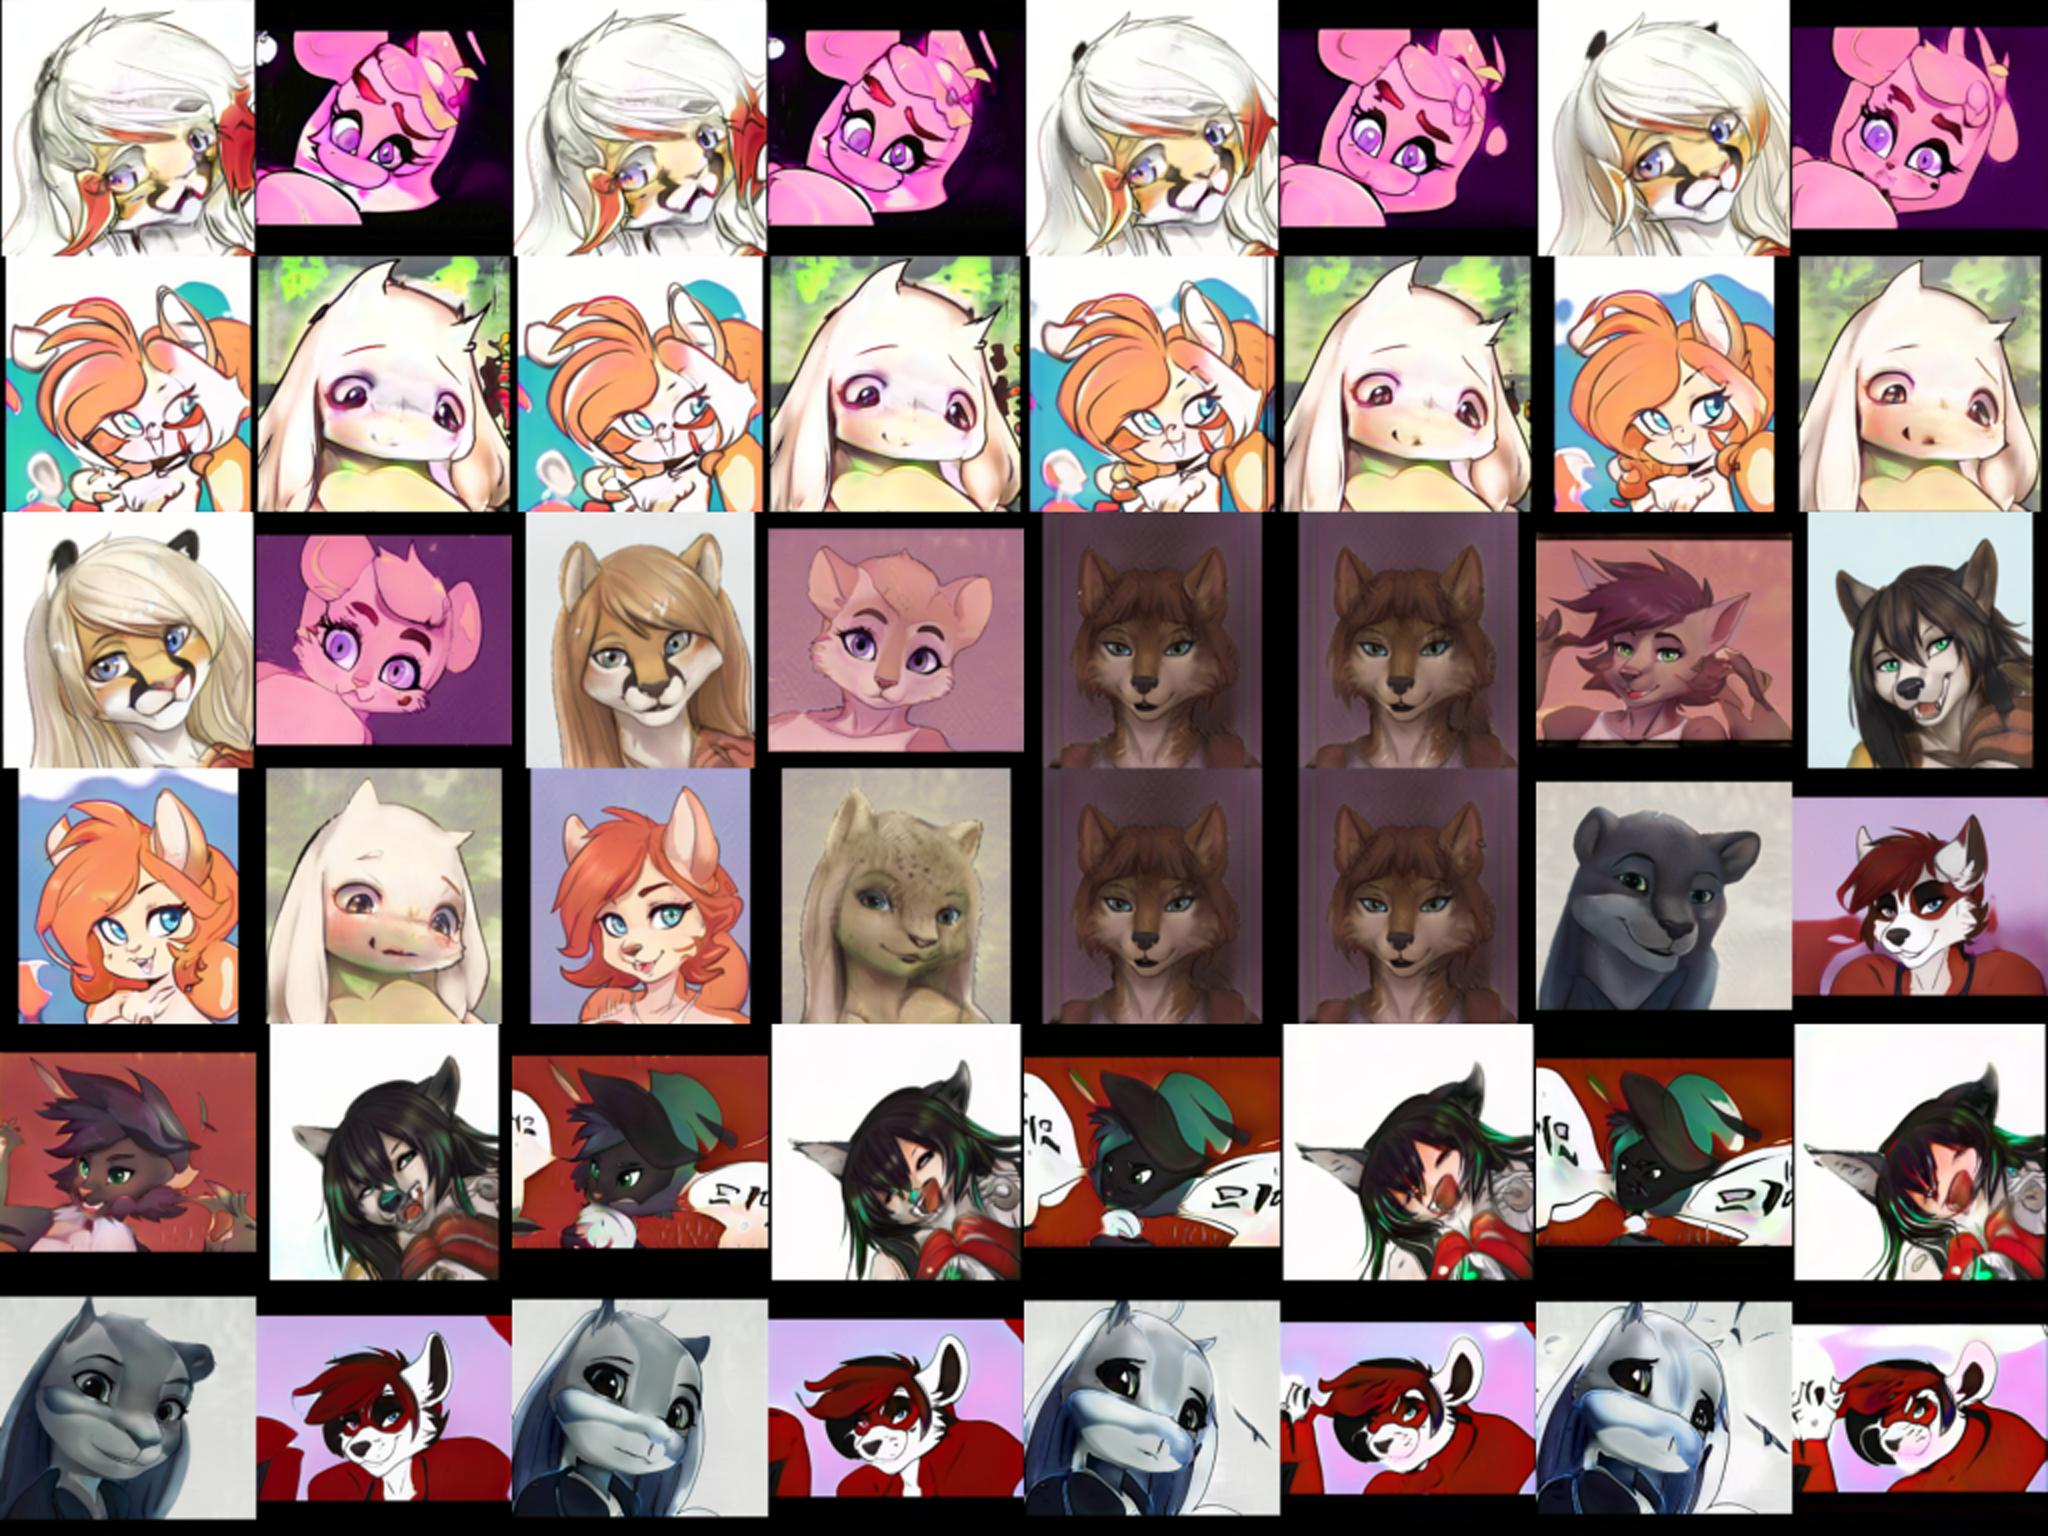

In [0]:
mosaic = make_mosaic(np.asarray(thumbnails))
mosaic = imresize(mosaic, max_side=2048) 
imshow(mosaic, retina=True, fmt='jpg')

In [0]:
video_out = out_path + '/StyleGanAnimation_' + str(random_seed) + '.mp4'
!ffmpeg -f image2  -framerate 8 -i "$seed_path/StyleGanImg_%01d.jpg" -b:v 8192k -r 30 -y -c:v libx264 "$video_out"

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
!ls -latr "$video_out"


-rw-r--r-- 1 root root 14413472 May 10 19:49 ./out/StyleGanAnimation_402.mp4
